# Introduction

Fit an Hidden Markov Model with Gaussian emissions to the data in DSET1: it is sufficient to focus on the “Appliances” and “Lights” columns of the dataset which measure the energy consumption of appliances and lights, respectively, across a period of 4.5 months. Consider the two columnsin isolation, i.e. train two separate HMM, one for appliances and one for light.  Experiment with HMMs with a varying number of hidden states (e.g. at least 2, 3 and 4). Once trained the HMMs, perform Viterbi on a reasonably sized subsequence (e.g. 1 month of data) and plot the timeseries data highlighting (e.g. with different colours) the hidden state assigned to each timepoint by the Viterbi algorithm.  Then, fit a single HMM emitting both appliance and light with the same model and repeat the Viterbi assessment. Confront the two results.

The full notebook is available [on GitHub](https://github.com/matteotolloso/ispr).

## Define useful functions

In [79]:
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [80]:
def train_and_plot_single(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    plot : bool = True
    ) -> np.array:   
    # create and train an HMM model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = hmm.GaussianHMM(n_components=n_components)
        model.fit(visible_sequence_train)
    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')
    if plot:
        # transform the numpy matrix into a 1-D list
        visible_sequence_test = [i[0] for i in visible_sequence_test]
        colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}
        # map the hidden states to colors
        colors_sequence = [colors_map[i] for i in hidden_sequence]
        plt.subplots(figsize=(21, 9))
        # set the x axis label
        plt.xlabel('Samplings (10min intervals)')
        # set the y axis label
        plt.ylabel('Value')
        # set the title
        plt.title(f'HMM Model with {n_components} hidden states')
        plt.bar(
            x = [i for i in range(len(visible_sequence_test))],
            height = visible_sequence_test,
            color = colors_sequence
        )
        plt.show()
    return hidden_sequence, model

def train_and_plot_double(
    visible_sequence_train,
    visible_sequence_test, 
    n_components : int = 2, 
    plot : bool = True
    ) -> np.array: 
    # create and train an HMM model
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = hmm.GaussianHMM(n_components=n_components)
        model.fit(visible_sequence_train)
    # predict the most likely sequence of internal hidden state
    prob, hidden_sequence = model.decode(visible_sequence_test, algorithm='viterbi')
    if plot:
        # transform the numpy matrix into a 1-D list
        visible_sequence_test_0 = [i[0] for i in visible_sequence_test]
        visible_sequence_test_1 = [i[1] for i in visible_sequence_test]
        colors_map = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "gray", 9: "olive", 10: "cyan"}
        # map the hidden states to colors
        colors_sequence = [colors_map[i] for i in hidden_sequence]
        plt.subplots(figsize=(21, 9))
        plt.xlabel('Samplings (10min intervals)')
        plt.ylabel('Value')
        plt.title(f'HMM Model with {n_components} hidden states. First feature.')
        plt.bar(
            x = [i for i in range(len(visible_sequence_test_0))],
            height = visible_sequence_test_0,
            color = colors_sequence
        )
        plt.show()
        plt.subplots(figsize=(21, 9))
        plt.xlabel('Samplings (10min intervals)')
        plt.ylabel('Value')
        plt.title(f'HMM Model with {n_components} hidden states. Second feature.')
        plt.bar(
            x = [i for i in range(len(visible_sequence_test_1))],
            height = visible_sequence_test_1,
            color = colors_sequence
        )
        plt.show()
    return hidden_sequence, model

# Dataset split and discussion on model selection

Since the values are sampled every 10 minutes, one day is represented by 144 points, one week by 1008 points and one month by 4320 points.

In [81]:
# get the column "Appliance" and "light" from the dataset
df = pd.read_csv("energydata_complete.csv", usecols=["Appliances", "lights"])

# trasfrorm the Appliances column into a numpy matrix
x_app = df["Appliances"].to_numpy().reshape(-1, 1)
x_light = df["lights"].to_numpy().reshape(-1, 1)

# split the x arrays in weeks, there are 19 weeks in the dataset
x_app = np.array_split(x_app, len(x_app) / 1008)
x_light = np.array_split(x_light, len(x_light) / 1008)

# the train set will be the first 7 weeks
train_set_app = x_app[:7]
train_set_light = x_light[:7]
train_set_app = np.concatenate(train_set_app)
train_set_light = np.concatenate(train_set_light)

# the validation set will be the subsequent 7 weeks
validation_set_app = x_app[7:14]
validation_set_light = x_light[7:14]
validation_set_app = np.concatenate(validation_set_app)
validation_set_light = np.concatenate(validation_set_light)

# the test set will be the 5 last weeks
test_set_app = x_app[14:19]
test_set_light = x_light[14:19]
test_set_app = np.concatenate(test_set_app)
test_set_light = np.concatenate(test_set_light)

I'm going to use the same time series size for training and validation in order to be able to compare the log-likelihood during the model selection.

From the scientific literature it is understood that the problem of selecting the right number of components is an open problem [[1]](https://link.springer.com/article/10.1007/s13253-017-0283-8) since maximizing likelihood leads to choosing a big number of components. 

In the following analysis i'm going to use the BIC critetia: $$BIC = -2*log\ p(x | \theta) + n*log(T) $$ where $x$ is the visible sequence, $n$ is the number of components and $T$ is the length of the sequence. The just mentioned papaer says "Under regularity conditions and for large samples, minimizing the BIC is approximately equivalent to maximizing the posterior model probability".

# Model selection

## Appliances dataset

In [82]:
train_app = []
validation_app = []
for i in range(1, 21):
    _, model = train_and_plot_single(
        visible_sequence_train=train_set_app, 
        visible_sequence_test=validation_set_app,
        n_components=i,
        plot=False
    )
    # BIC score
    train_app.append( -2 * model.score(train_set_app, lengths = [len(train_set_app) - 1]) + (i * np.log(len(train_set_app)))  )
    validation_app.append(-2 * model.score(validation_set_app, lengths  = [len(validation_set_app) - 1]) + (i * np.log(len(validation_set_app))))


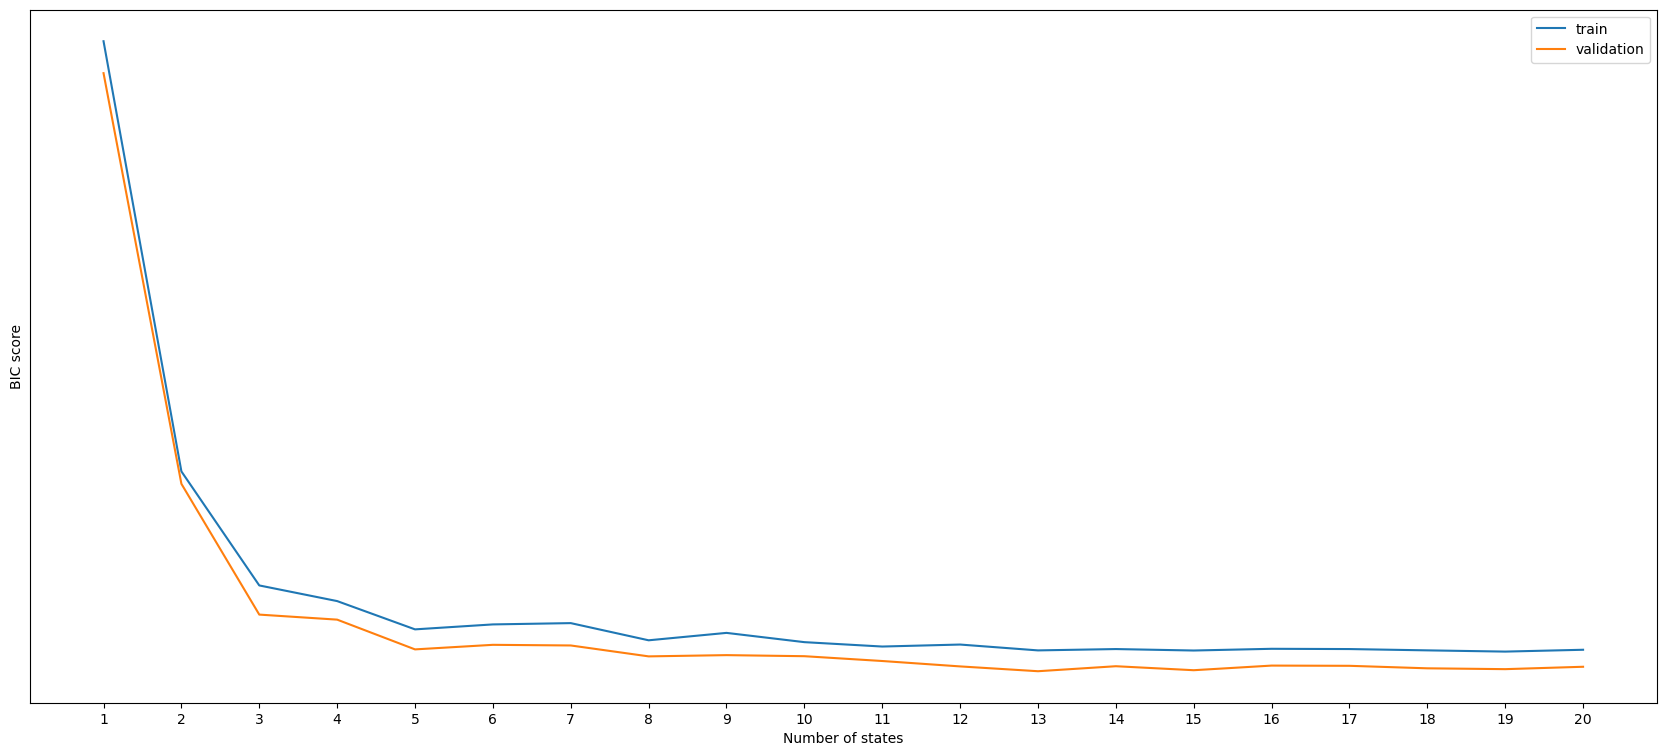

In [83]:
# plot the train and validation scores
plt.subplots(figsize=(21, 9))
plt.plot(range(1, len(train_app)+1), train_app, label="train")
plt.plot(range(1, len(validation_app)+1), validation_app, label="validation")
plt.xticks(range(1, len(train_app)+1))
plt.yticks([])
plt.xlabel("Number of states")
plt.ylabel("BIC score")
plt.legend()
plt.show()

From the plot of the BIC we can see that there is a plateau after 5 components, i.e. there are only little improvements in the likelihood at the cost of an higher number of components.

## Lights dataset

In [84]:
train_light = []
validation_light = []
for i in range(1, 21):
    _, model = train_and_plot_single(
        visible_sequence_train=train_set_light, 
        visible_sequence_test=validation_set_light,
        n_components=i,
        plot=False
    )
    train_light.append( -2 * model.score(train_set_light, lengths = [len(train_set_light) - 1]) + (i * np.log(len(train_set_light)))  )
    validation_light.append(-2 * model.score(validation_set_light, lengths  = [len(validation_set_light) - 1]) + (i * np.log(len(validation_set_light))))

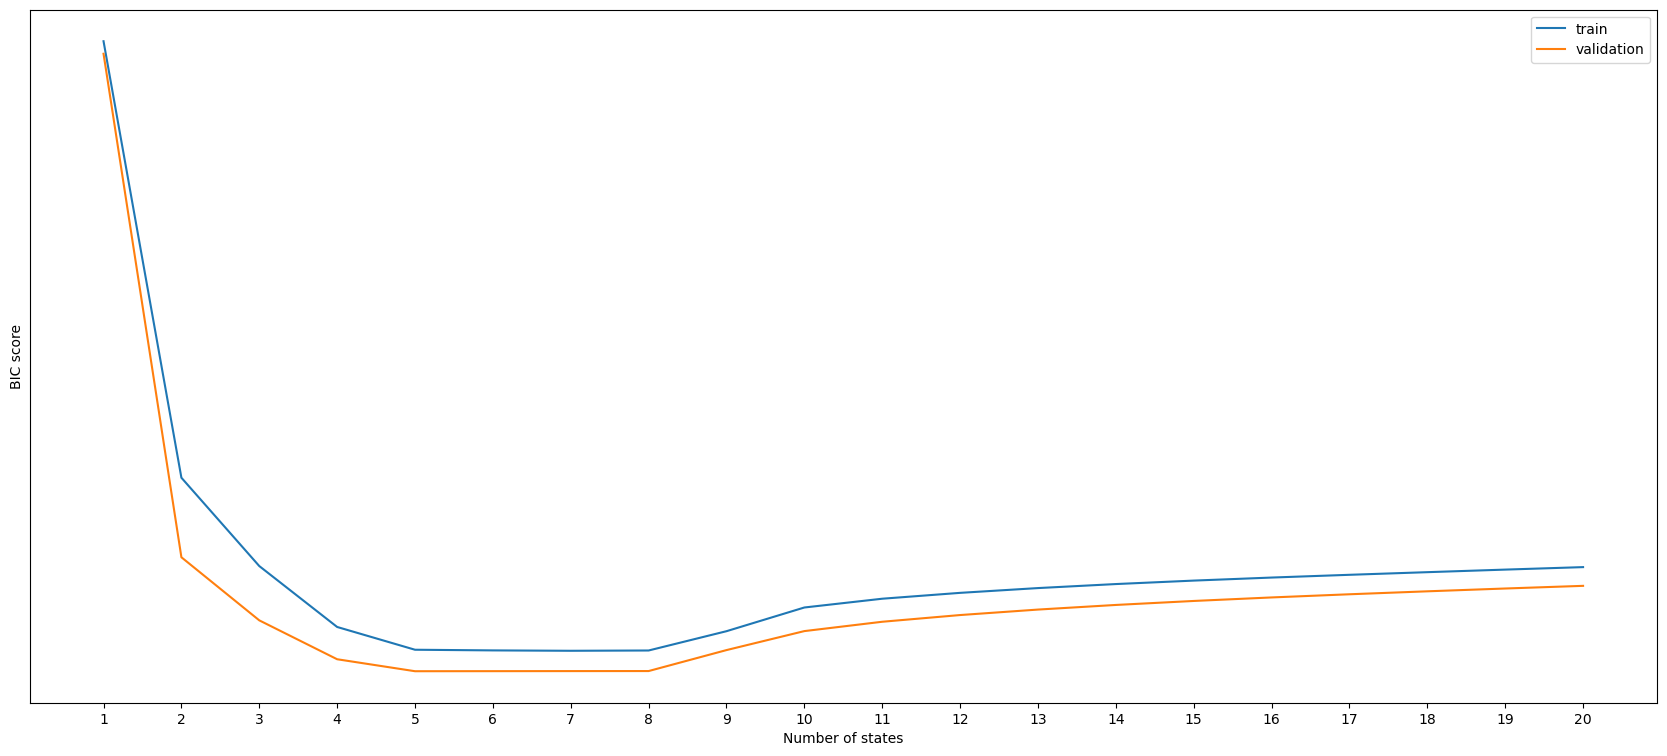

In [85]:
# plot the train and validation scores
plt.subplots(figsize=(21, 9))
plt.plot(range(1, len(train_light)+1), train_light, label="train")
plt.plot(range(1, len(validation_light)+1), validation_light, label="validation")
plt.xticks(range(1, len(train_light)+1))
plt.yticks([])
plt.xlabel("Number of states")
plt.ylabel("BIC score")
plt.legend()
plt.show()

This plot is more easy to interpret than the previous one because the penality term of the BIC starts to be relevant after 10 components. I think that also in this case the optimal number of components is 5.

We can also notice that in the lights dataset the number of different observed values is 8, exactly the number of component when the BIC starts to increase.

## Double emission distribution

Let's join again the two features of the timeseries in a single matrix in order to train an HMM with two emission distributions.

In [86]:
# join the two features in a single matrix

train_set_mixed = np.concatenate((train_set_app, train_set_light), axis=1)
validation_set_mixed = np.concatenate((validation_set_app, validation_set_light), axis=1)
test_set_mixed = np.concatenate((test_set_app, test_set_light), axis=1)

test_set_mixed.shape

(5190, 2)

In [87]:
train_mixed = []
validation_mixed = []
for i in range(1, 21):
    _, model = train_and_plot_double(
        visible_sequence_train=train_set_mixed, 
        visible_sequence_test=validation_set_mixed,
        n_components=i,
        plot=False
    )
    train_mixed.append( -2 * model.score(train_set_mixed, lengths = [len(train_set_mixed) - 1]) + (i * np.log(len(train_set_mixed)))  )
    validation_mixed.append(-2 * model.score(validation_set_mixed, lengths  = [len(validation_set_mixed) - 1]) + (i * np.log(len(validation_set_mixed))))

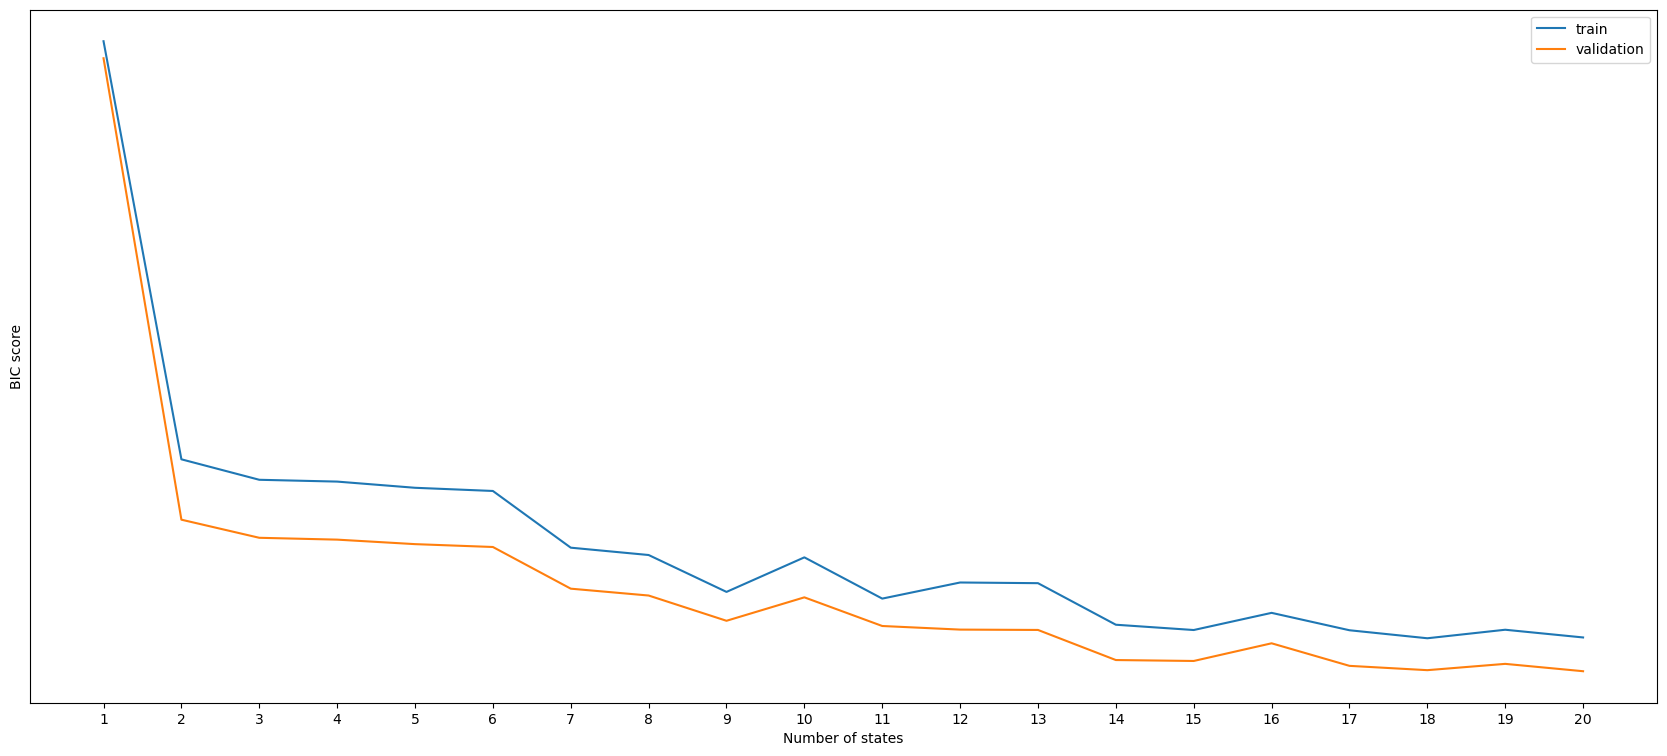

In [88]:
# plot the train and validation scores
plt.subplots(figsize=(21, 9))
plt.plot(range(1, len(train_mixed)+1), train_mixed, label="train")
plt.plot(range(1, len(validation_mixed)+1), validation_mixed, label="validation")
plt.xticks(range(1, len(train_mixed)+1))
plt.yticks([])
plt.xlabel("Number of states")
plt.ylabel("BIC score")
plt.legend()

In this final plot we have a similar behaviour to the one of the appliances dataset (no increase in the BIC for these 20 tests) but the plateau arrives much later, around 15 components, sign that a duble emission is harder to fit.

# Results

## Single emission

### Appliances

Let's compare the hidden chain with the observations.

Here I plot the time series of the appliances dataset test set (5 weeks), the colors of the bins represent the hidden states assigned by Viterbi algorithm.

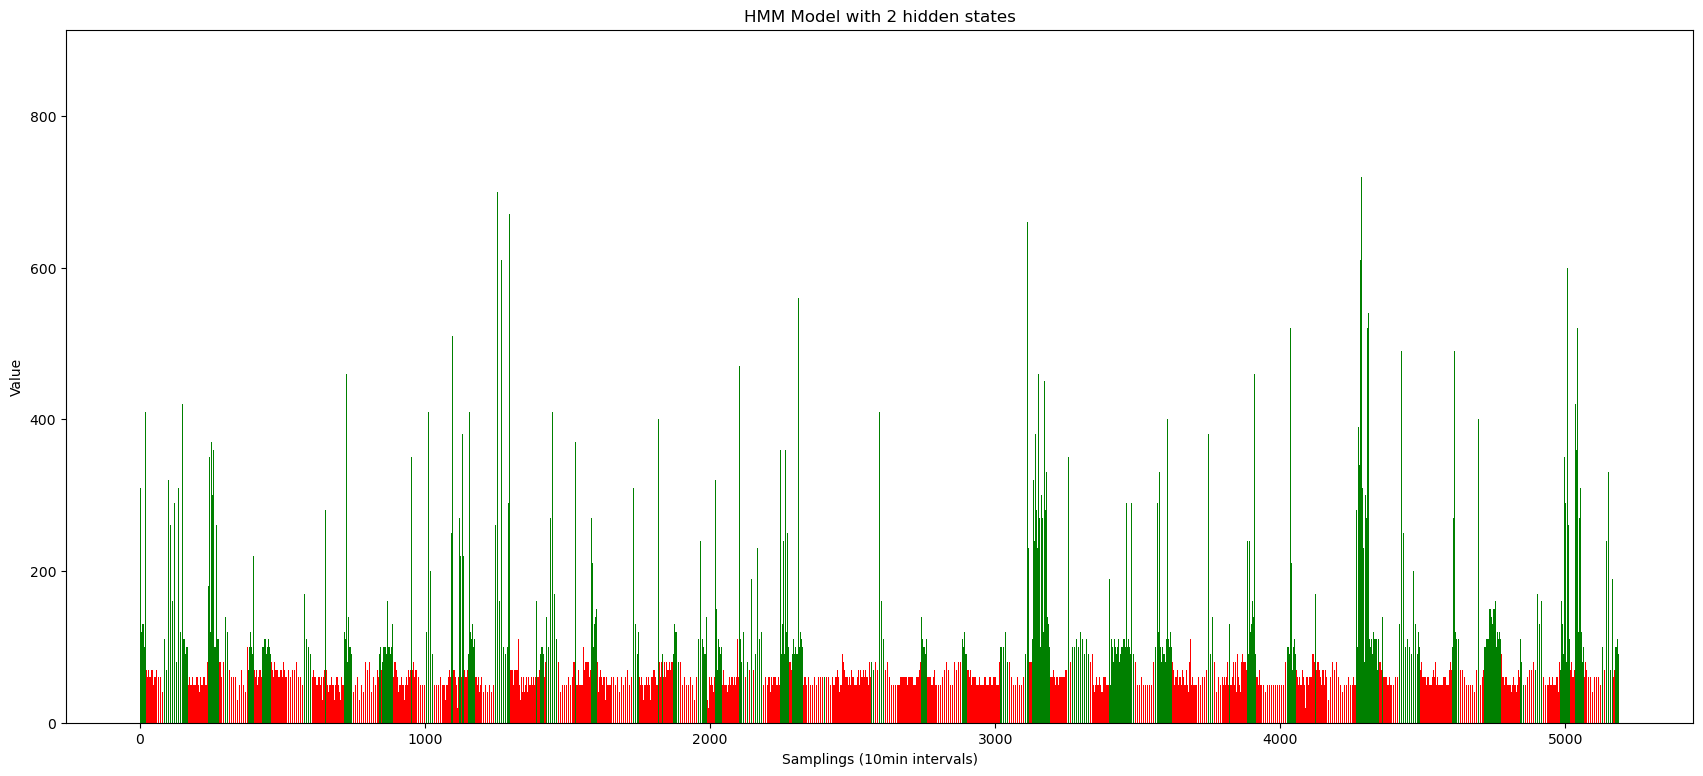

In [89]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_app, 
    visible_sequence_test=test_set_app,
    n_components=2,
    plot=True
)

Increasing the number of components the hidden states of the model are able to better approximate the time series. In this particular case the blue states can be interpreted as period of high consumption, while the red states as period of low consumption.

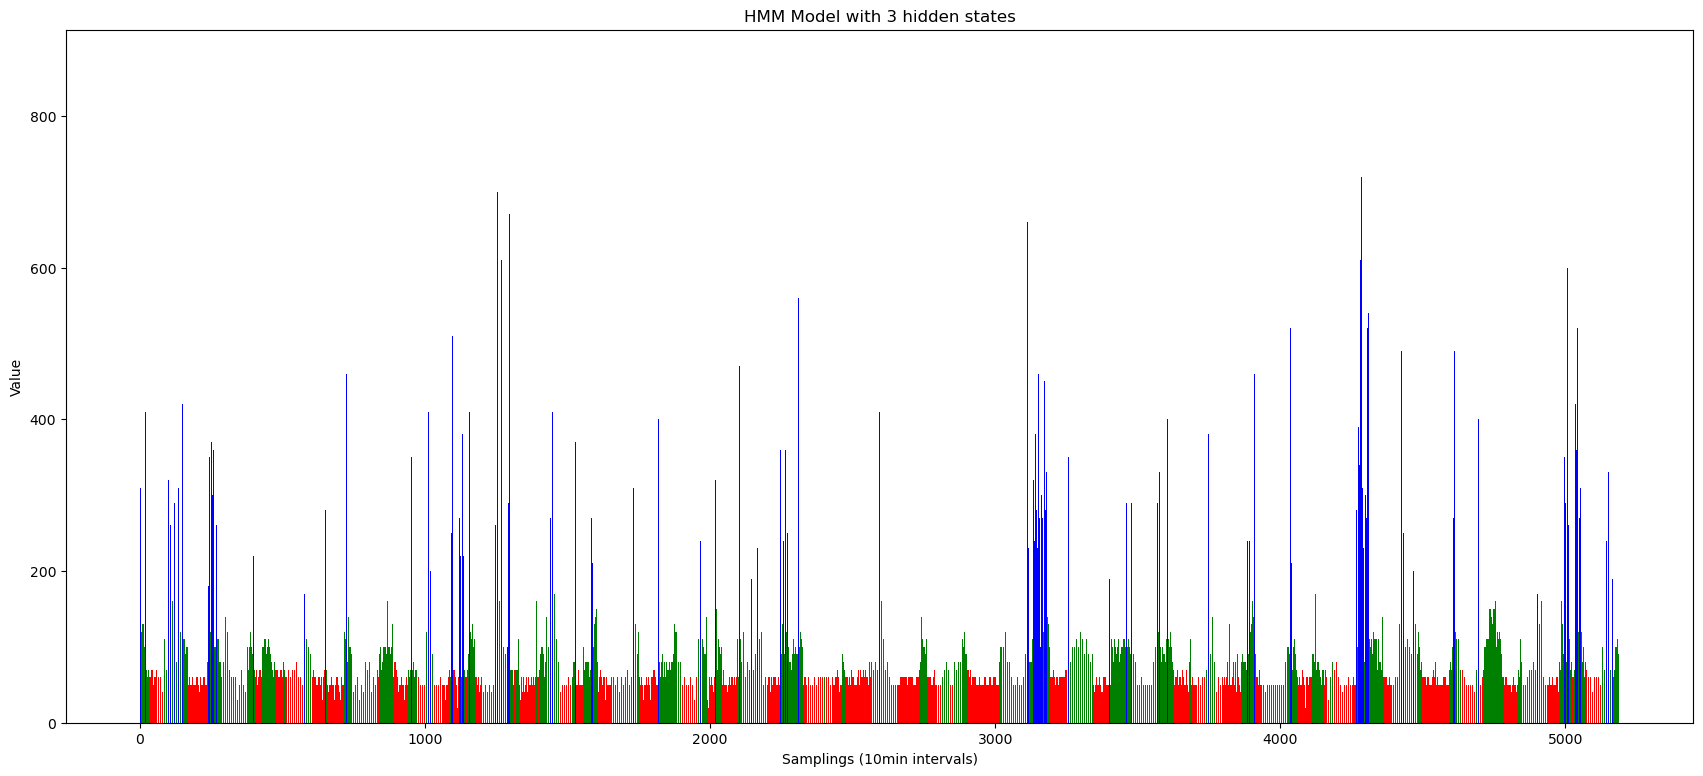

In [90]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_app, 
    visible_sequence_test=test_set_app,
    n_components=3,
    plot=True
)

Increasing the number of components, the results are always better.

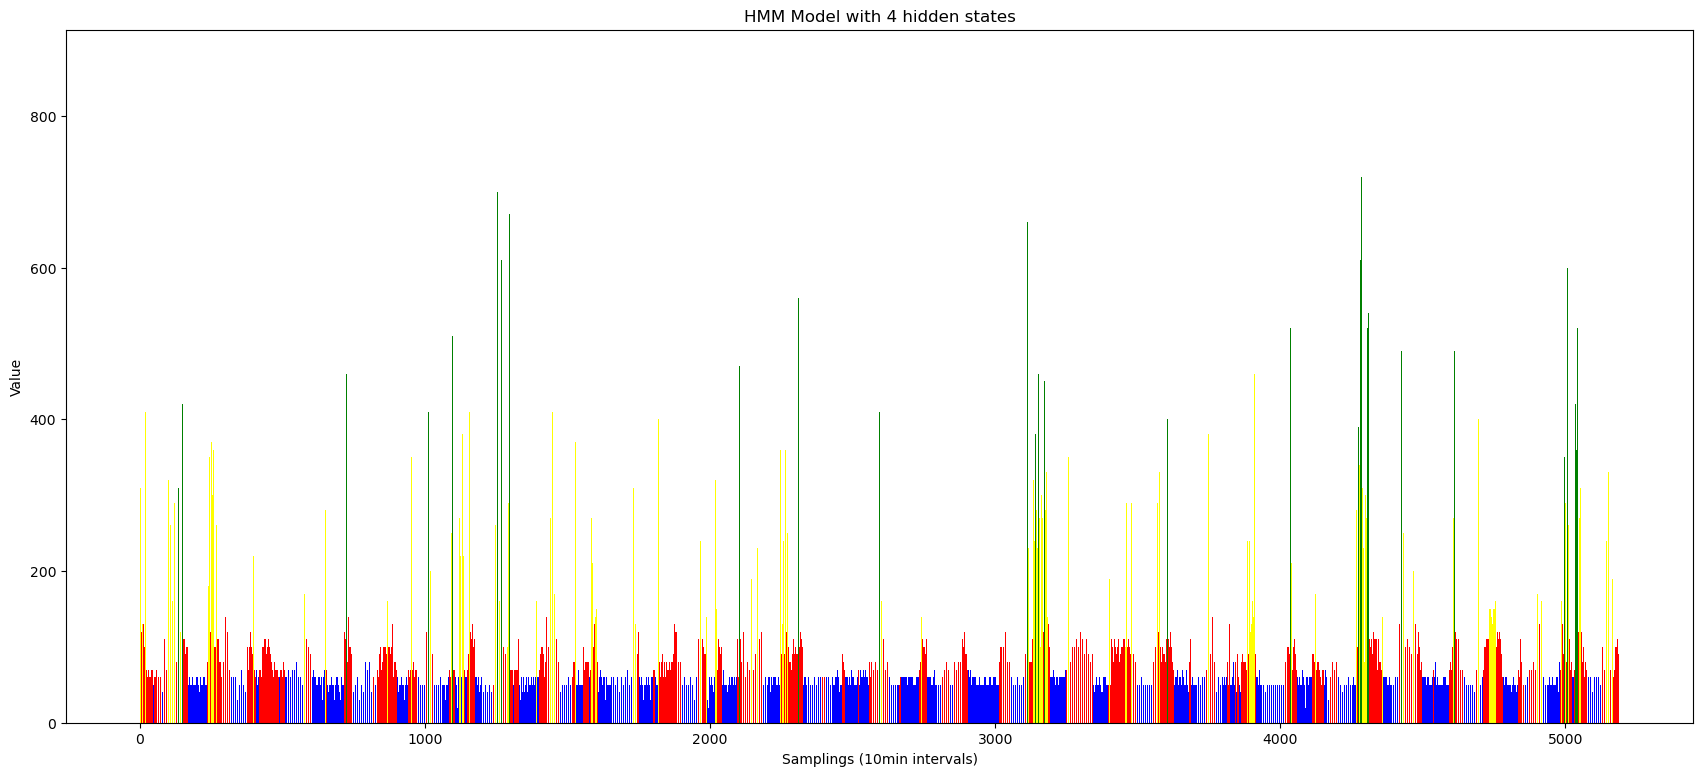

In [95]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_app, 
    visible_sequence_test=test_set_app,
    n_components=4,
    plot=True
)

### Lights

The same behavior is observed for the light dataset, in this case the red states are periods of zero lights (not visible from the plot).

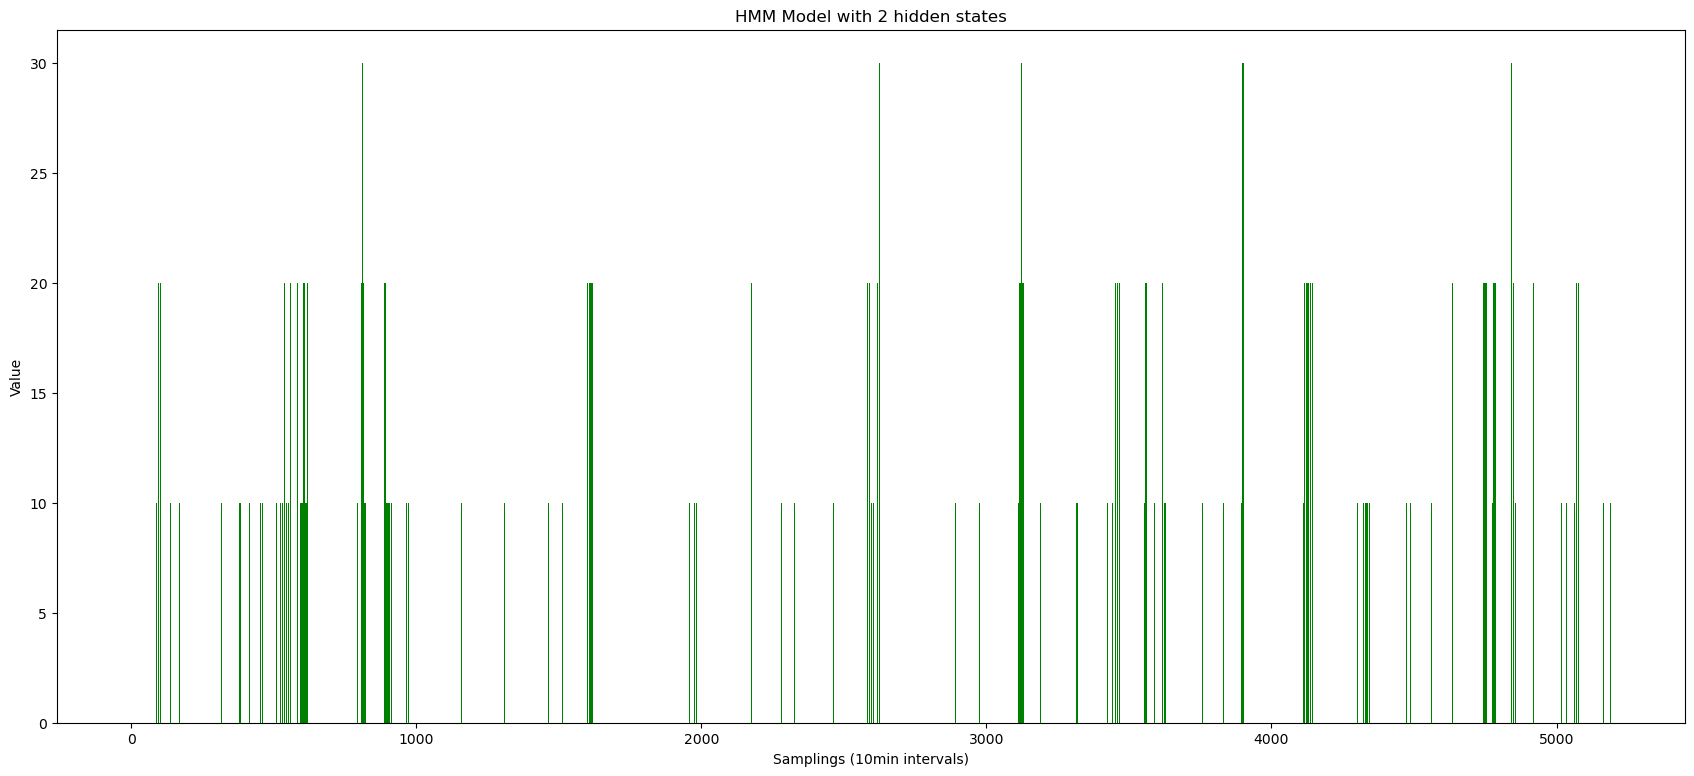

In [91]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_light, 
    visible_sequence_test=test_set_light,
    n_components=2,
    plot=True
)

With 3 components instead, the hidden dynamic is able to distinguish the period with zero lights, 10 lights and 20 or more lights.

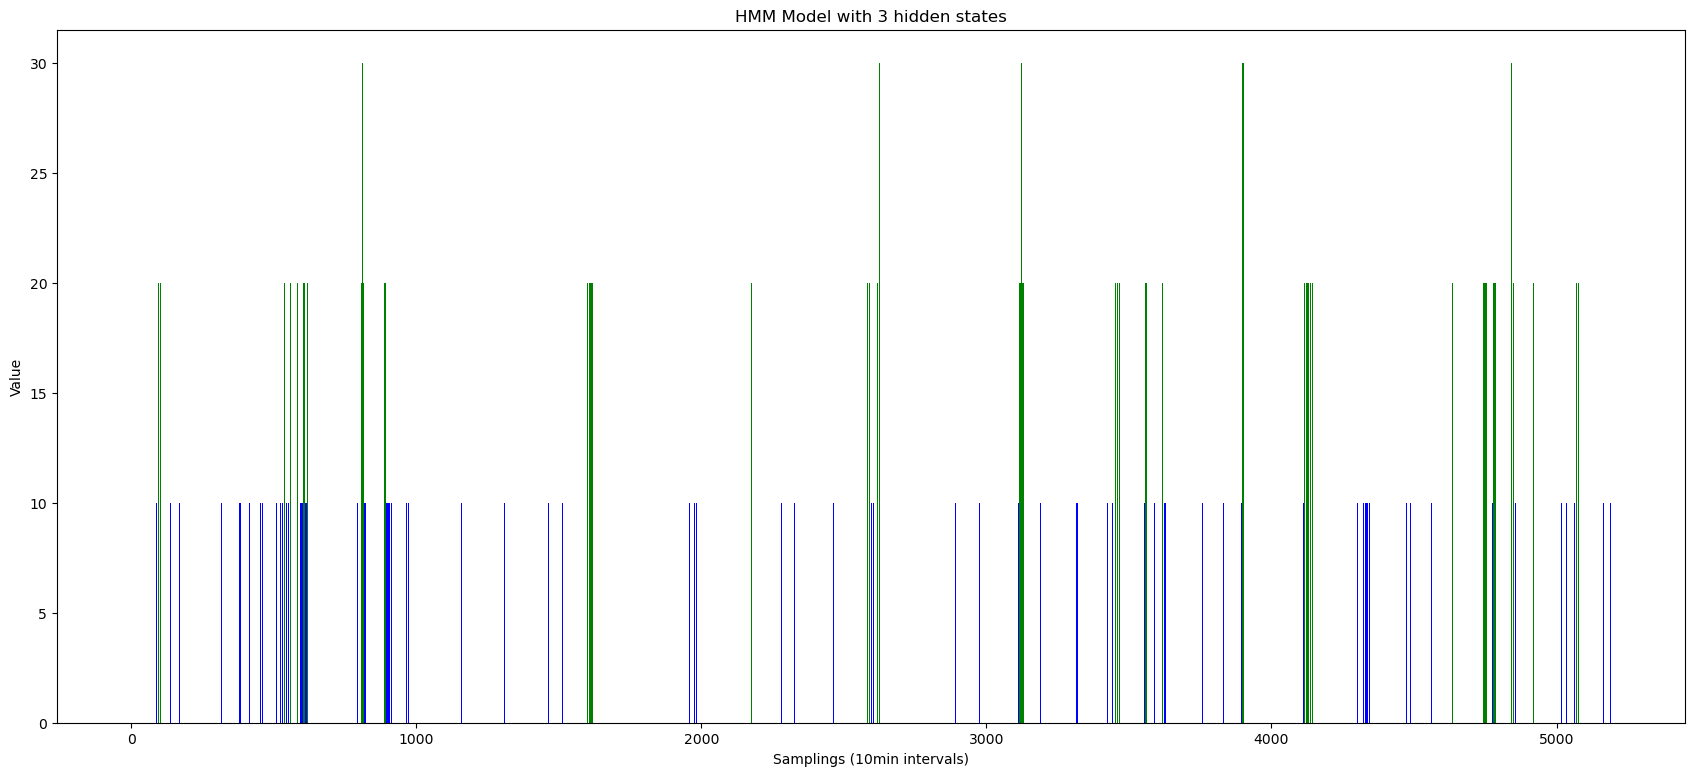

In [92]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_light, 
    visible_sequence_test=test_set_light,
    n_components=3,
    plot=True
)

Finally, with 4 components the model is able to assign a different hidden state to each different observed value (only 0, 10, 20, 30 in this test set).

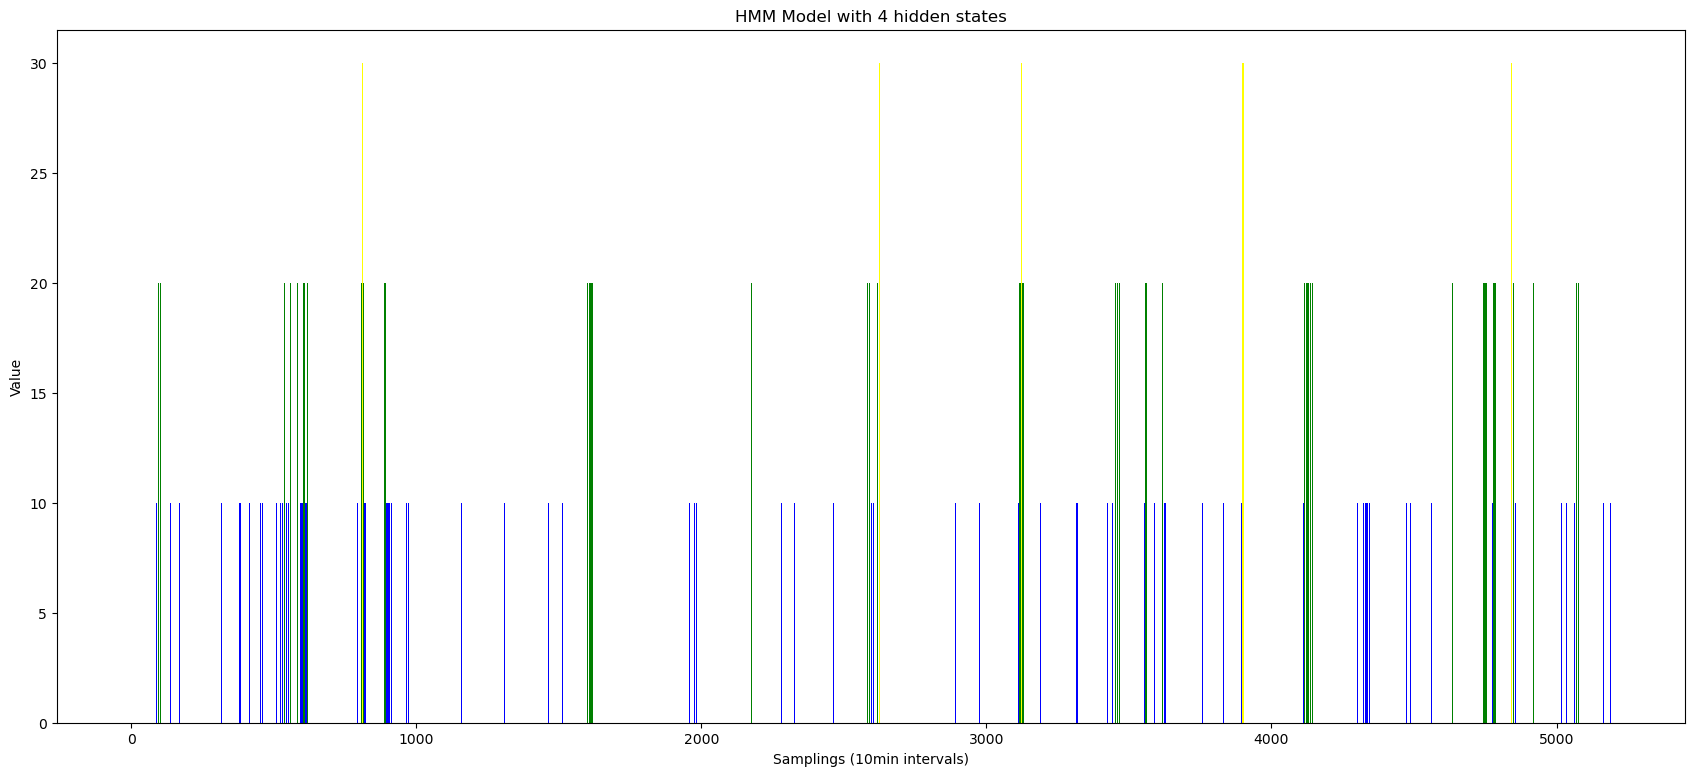

In [97]:
_, _ = train_and_plot_single(
    visible_sequence_train=train_set_light, 
    visible_sequence_test=test_set_light,
    n_components=4,
    plot=True
)

## Double emission

Moving to the double emission distribution, it's possible to see that is more difficult for the hidden state of the model to understand in wich period of "consumption" we are in, since it has to model with the same transition distribution two processes that could have a different internal logic.

Particularly, in the first feature plot (appliances), we can see a lot of timestamp of low consumption for which the corresponding hidden state is red, that usually is assigned to the high consumption period. This didn't happen when the model was trained on the appliances dataset only.

The second feature has not deteriorated with respect to the single emission fit in the case of 2 components.

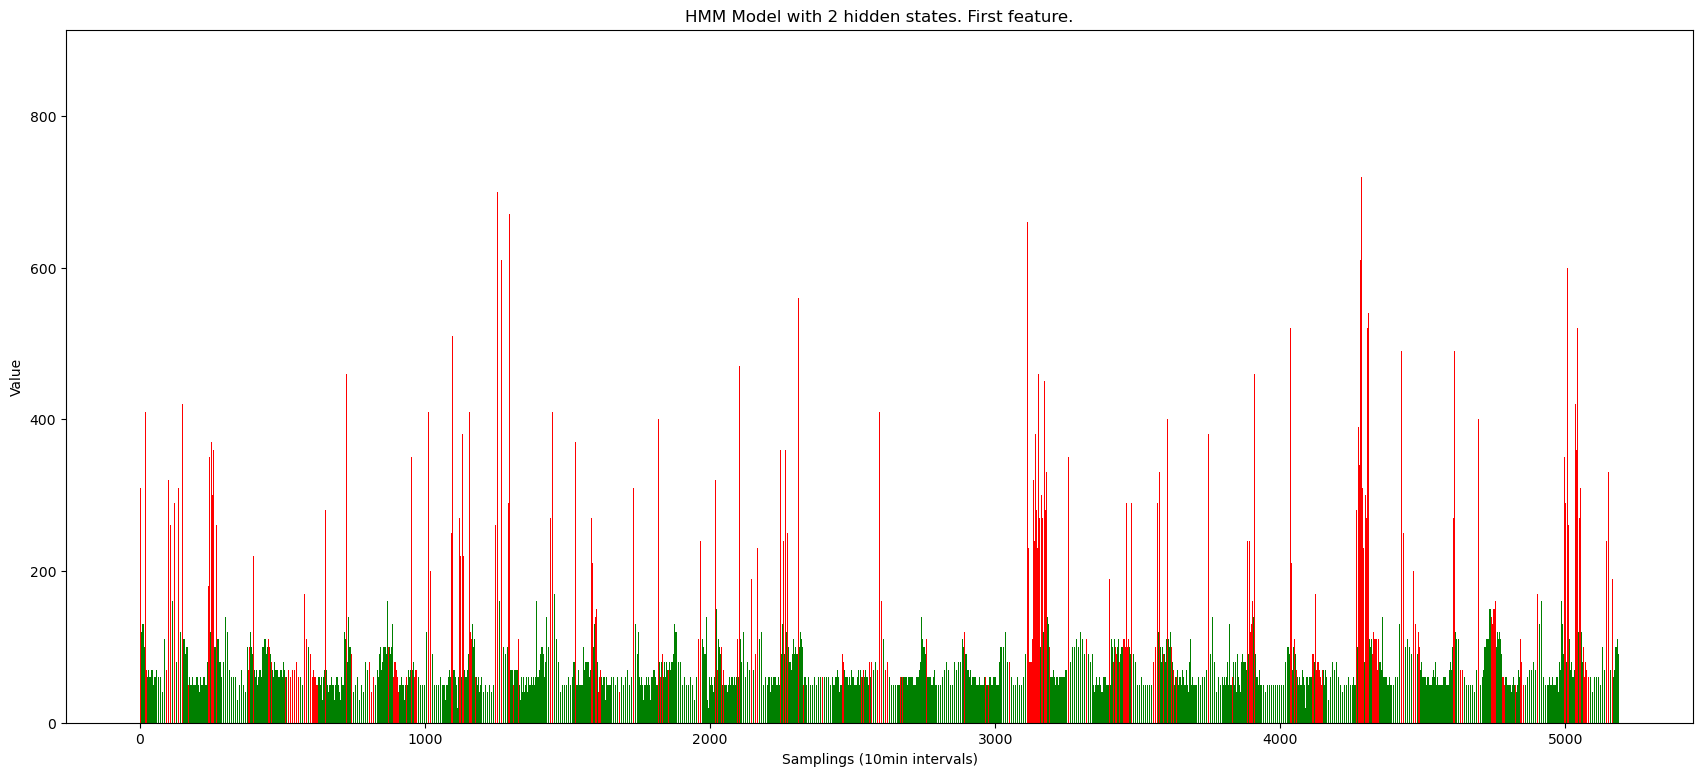

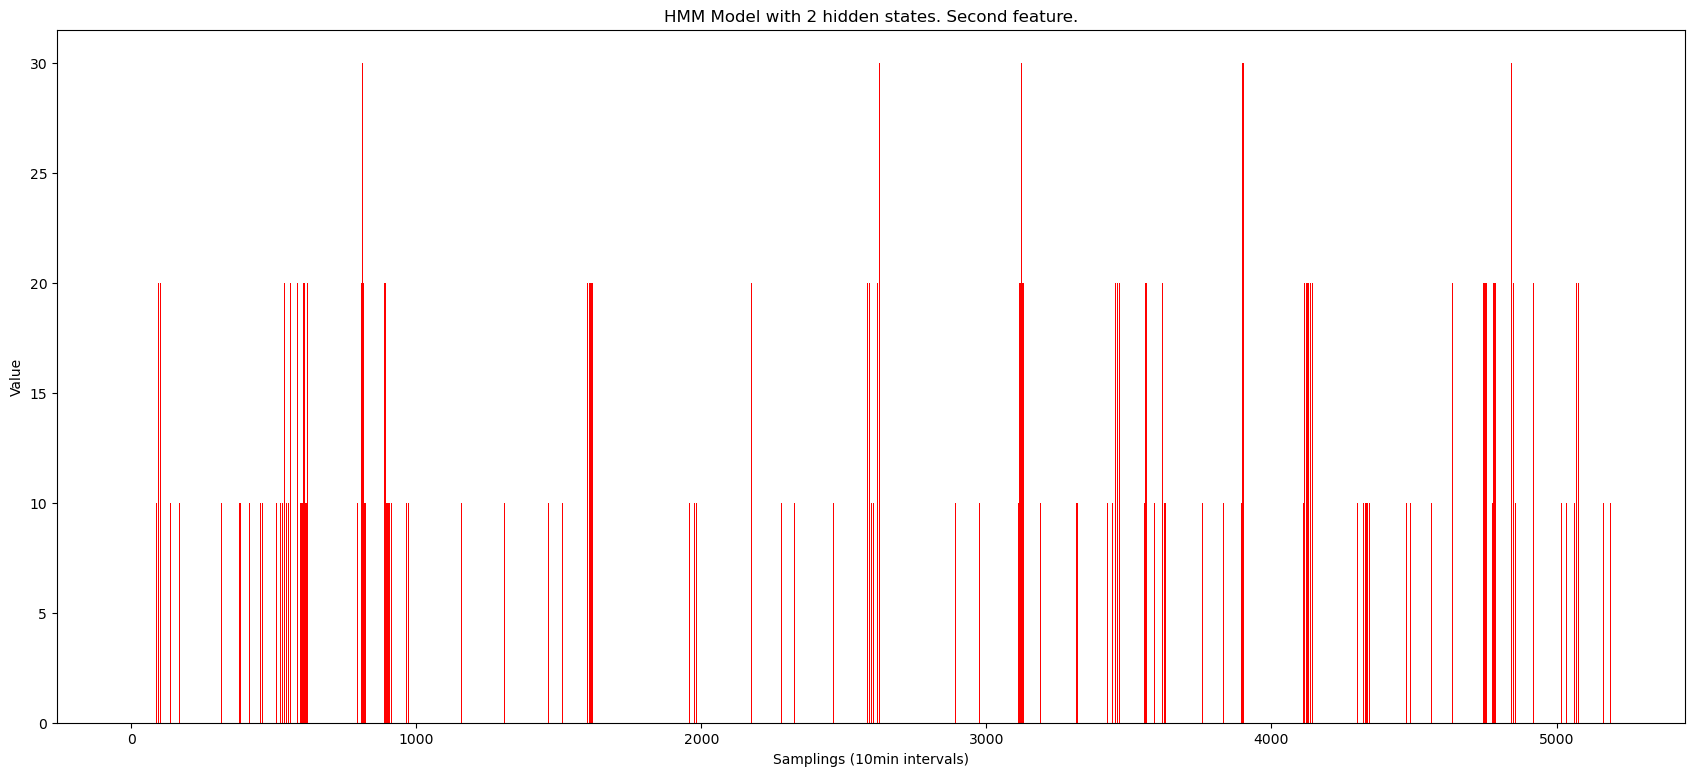

In [93]:
_, _ = train_and_plot_double(
    visible_sequence_train=train_set_mixed, 
    visible_sequence_test=test_set_mixed,
    n_components=2
)

Plotting the hidden states with 3 components, we see the the results are worse than the single emission distribution also for the light feature.

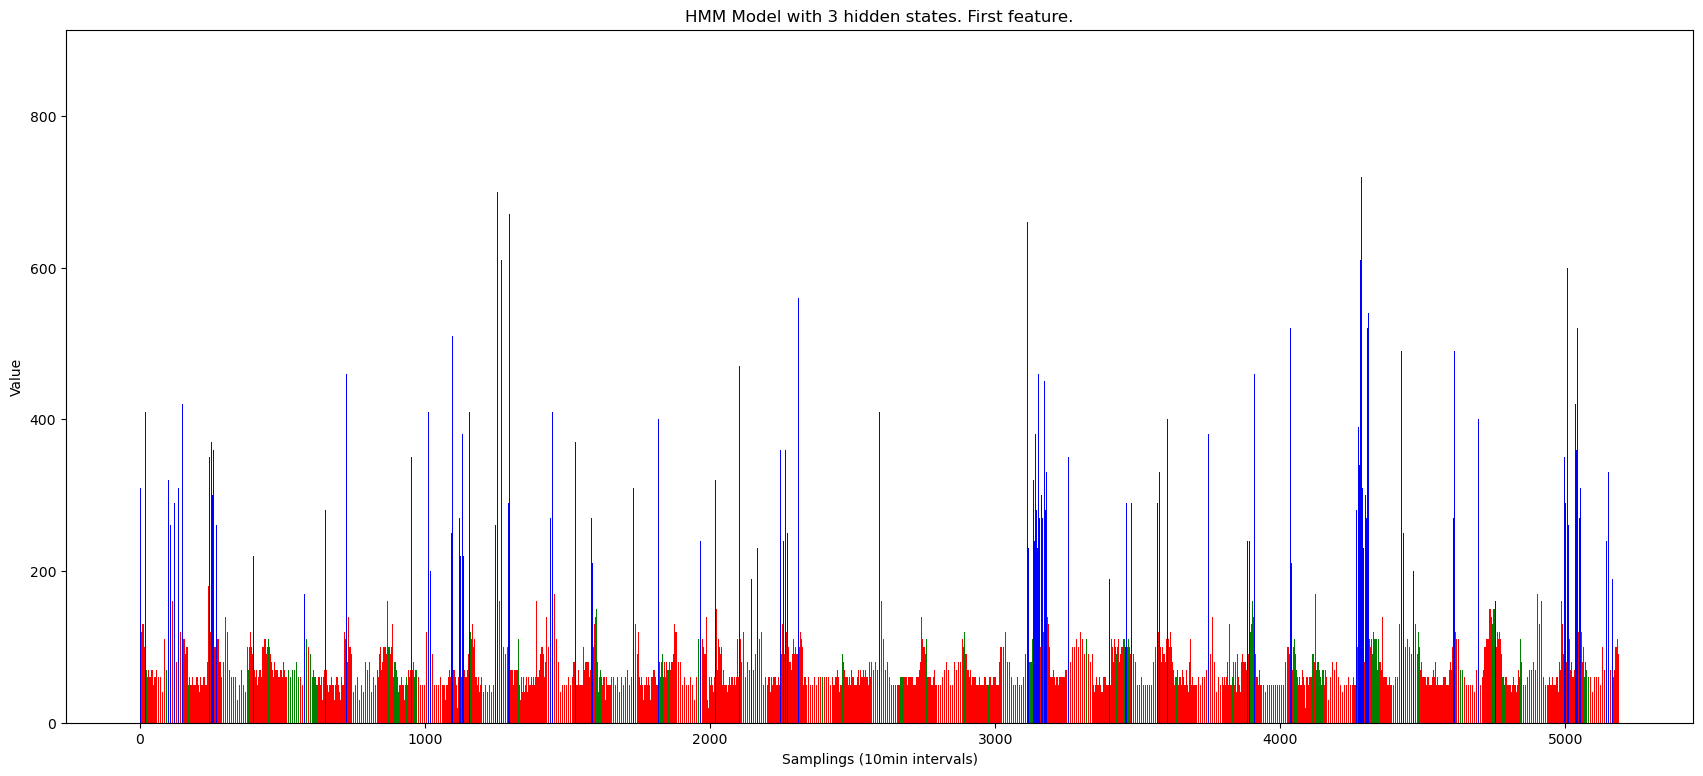

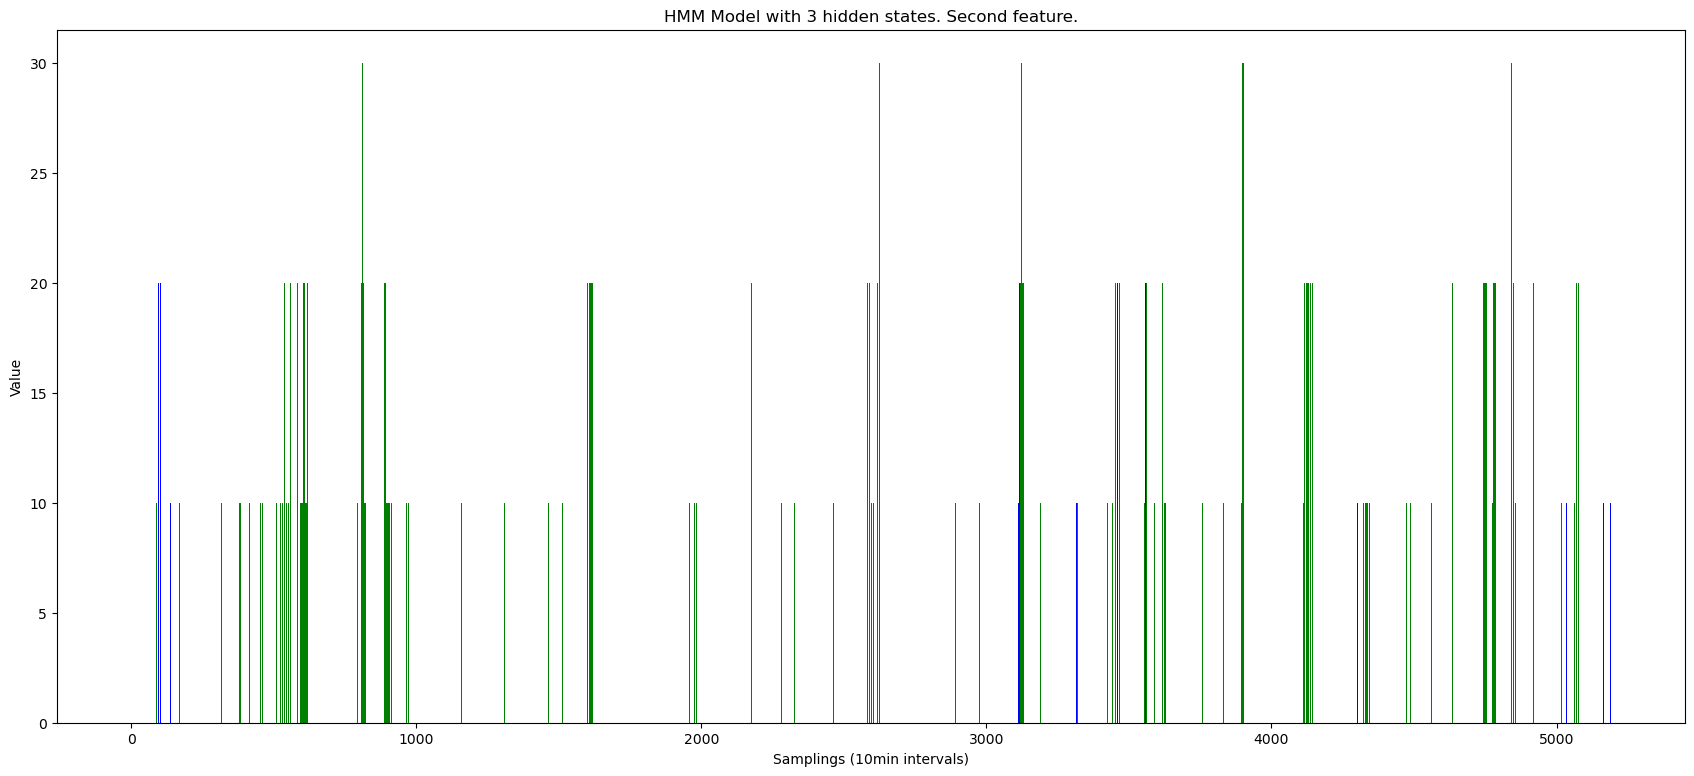

In [94]:
_, _ = train_and_plot_double(
    visible_sequence_train=train_set_mixed, 
    visible_sequence_test=test_set_mixed,
    n_components=3
)